# Extracting informations from Text using Text Mining Techniques

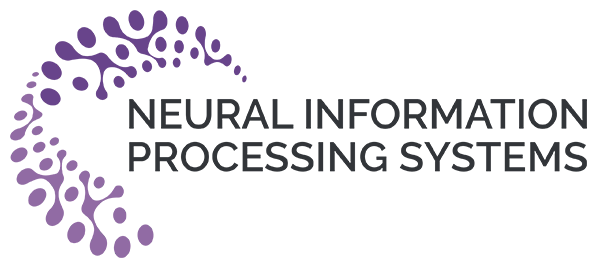

**Neural Information Processing System (NIPS) is one of the top machine learning conferences in the world. It covers topics ranging from deep learning and computer vision to cognitive science and reinforcement learning.** My intention is to extract as much information as possible from this data, and try all the text mining techniques on this dataset.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud
import spacy
nlp = spacy.load('en_core_web_sm')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

Here we will work with only papers file.

In [ ]:
data = pd.read_csv("/kaggle/input/nips-papers/papers.csv")
data.head()

In [ ]:
print(data.columns)
print(len(data.columns))

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
data.isnull().sum()

In [ ]:
sns.set_style("dark")
graph = sns.catplot(data=data, x="year", kind="count", height = 4.5, aspect = 2.5, palette = "hls")
graph.set_xticklabels(rotation=90)
plt.title("Frequency showing number of papers released in different years", size = 20)

So the above chart represents that in our dataset most papers got released for the year 2017. Now let's look at the text a little.

In [ ]:
pd.set_option('display.max_colwidth', None)
data["paper_text"].head()

Hmmm... So our text size is quite big. Let's find out word-size for the texts using histogram. Let's just roughly get an idea before cleaning the text.

In [ ]:
data['Number_of_words'] = data['paper_text'].apply(lambda x:len(str(x).split()))

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="red", bins = 100)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

In [ ]:
plt.figure(figsize = (10,6))
data["Number_of_words"].plot(kind="box")
plt.title("Word frequency distribution using Box plot", size = 16)

In [ ]:
data.drop(data[data["Number_of_words"]<200].index, inplace = True)

So using the above code I have removed all the texts which are less than 200 words, basically there were only 3 rows, which contains data of this small size.

In [ ]:
data.shape

Now we will try to see how many documents have words count between 200 and 500.

In [ ]:
len(data[(data["Number_of_words"]>200) & (data["Number_of_words"]<500)])

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="blue", bins = 100)
plt.title("Frequency distribution of number of words for each text extracted after removing 3 columns", size=18)

# Text Cleaning

Now let's start the text cleaning process.

In [ ]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
data["cleaned_paper_text"]=data["paper_text"].apply(cleaned_text)

In [ ]:
data["cleaned_paper_text"] = data["cleaned_paper_text"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [ ]:
data["cleaned_paper_text"].head(10)

Now let's try to create a wordcloud from this cleaned text.

In [ ]:
cloud=WordCloud(colormap="winter",width=600,height=400).generate(str(data["cleaned_paper_text"]))
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

Now we will do the next step cleaning process which is stop word removal and then we will lemmatize the words.

In [ ]:
stop=stopwords.words('english')
stop.append("also")
data["stop_removed_paper_text"]=data["cleaned_paper_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
data["tokenized"]=data["stop_removed_paper_text"].apply(lambda x: nltk.word_tokenize(x))

In [ ]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
data["lemmatized"]=data["tokenized"].apply(lambda x: word_lemmatizer(x))
data["lemmatize_joined"]=data["lemmatized"].apply(lambda x: ' '.join(x))

In [ ]:
data["lemmatize_joined"].head()

Now let's see how the word distribution has changed using a histogram after doing some text cleaning.

In [ ]:
data['Number_of_words_for_cleaned'] = data['lemmatize_joined'].apply(lambda x:len(str(x).split()))

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words_for_cleaned'],kde = False, color= "navy", bins = 100)
plt.title("Frequency distribution of number of words for each text extracted after removing stopwords and lemmatization", size=16)

So we can clearly see the shift after stopword removal. Now let's see the top 30 most frequent words in our whole text. Also let's remove documents with word size more than 6000, cause we don't want to deal with at the moment a document of this size.

In [ ]:
data.drop(data[data["Number_of_words_for_cleaned"]>4500].index, inplace = True)

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words_for_cleaned'],kde = False, color= "orangered", bins = 100)
plt.title("Frequency distribution of no of words in the documents after removing docs containing > 4500 words", size=15)

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(data["lemmatize_joined"]).split()).value_counts()[:30]
freq.plot(kind="bar", color = "orangered")
plt.title("30 most frequent words",size=20)

So in the above we can see that there are still some stopwords present, but I want to keep them, as they are adding some meaning to our text. Now let's do vectorization, using 

# Vectorization using Word2vec

Before begining, word2vec takes list of words as an input to train the neural network model. Word2vec is a neural network with 1 hidden layer. Input layer takes the vocabulary of words, and hidden layer's size is the vector size of the word that we want, so here we will be giving 250 as the hidden layer size or we want size of the vectors for each word to be 250.

In [ ]:
tokens = data["lemmatize_joined"].apply(lambda x: nltk.word_tokenize(x))

So what's happening below is we are giving the list of words, and we are limiting some words, meaning, we are allowing those words in our vocabulary in the model, whose frequency is more than 600 using **min_count**, as we want a little cleaner t-sne plot, otherwise the plot will be a huge mess, as their are too much words in our data, so to make it a little cleaner, I just limited it to the words which has a frequency of above 600, also the vector size of a word here will be 250 and we defined it using **size**, and for **window** 10 mean, for a word, it will look 10 words right to it and 10 words to it's left. **Alpha** and **min_alpha** are the learning rates, so we will start with the learning rate of 0.03, and later near optimization, the learning rate will lower down to 0.0007, to find the optimized weights.

In [ ]:
w2v_model = Word2Vec(tokens,
                     min_count=600,
                     window=10,
                     size=250,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed = 42)

Now let's see the vector representation of the word "model".

In [ ]:
v1 = w2v_model.wv['model']
print(v1)

So it's a vector of 250 numbers, as described by us while creating the model, and each dimension represents some aspect of the word. Now let's see some similar words.

# Similar words using Word2vec

In [ ]:
sim_words = w2v_model.wv.most_similar('estimator')
print(sim_words)

In [ ]:
sim_words_2 = w2v_model.wv.most_similar('synapse')
print(sim_words_2)

In [ ]:
sim_words_3 = w2v_model.wv.most_similar('connectivity')
print(sim_words_3)

# TSNE Plot for 2 models

About T-SNE, it is mainly used for showing high dimensional figure to a lower dimensional figure. So here, as we know the words has a dimension of 250, and we are showing it in 2-D figure, just imagine! This is the job of T-SNE. So the concept says, similar words will have similar vectors, and so those similar words will be closer in the vector space, or sometimes may even overlap, if they are too similar.

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 13)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
tsne_plot(w2v_model)

Now let's create another model, and this time we will be using words with frequency more than 2000 and plot it using T-SNE, so that our plot looks a little more cleaner. But I believe this shouldn't be done, as words which are repeating 1000 times or more in the corpus, must have some importance, I am doing this just to show the plot a little cleaner, it is not recommended at all.

In [ ]:
w2v_model_2 = Word2Vec(tokens,
                     min_count=1000,
                     window=10,
                     size=250,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed=50)

In [ ]:
tsne_plot(w2v_model_2)

**Work in progress.**

# Topic Modelling using LDA

The input will be in the form of document-term matrix, and we will convert that using the below piece of code.

In [ ]:
dictionary = corpora.Dictionary(data["lemmatized"])
doc_term_matrix = [dictionary.doc2bow(rev) for rev in data["lemmatized"]]

Let's try for number of topics 5, we will keep on changing this, if we don't get better result.

In [ ]:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100,
                chunksize=200, passes=100)

In [ ]:
lda_model.print_topics()

Now let's see the coherence score of this.

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model,
texts=data["lemmatized"], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Basically 4 is not the optimum number of topics, we can find the optimum number by finding **coherence score** for different number of topics, and chosing topic with highest **coherence score**. Here I tried to save time, as I tried to plot coherence score for different topic numbers, but it was taking too much time, but very soon I will do that part for this dataset.

**Now let's generate wordcloud for each topic.**

# WordClouds for Topics' Keywords

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

# Dominant topic for each Document

Using below piece of code we will try to find the dominant topic for each document. As we all know from the concept of LDA that each document is made up of different topics, for example in our case there are 4 topics in our case in total, and suppose for a document, it is made up of 70% of topic 1, and the rest consists of the rest topics distributed in some ways, so we are trying to find that dominant topic for each document using the below piece of code.

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=data["lemmatized"])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Keyword above represents the most occuring words for a particular topic. Also there is weight of that topic in that document. This is so good!! Isn't it?? I am so thrilled!!

In [ ]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data["lemmatized"] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,7), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

Here I have limited the word count to 3500.

Now let's see how many documents belong to each topic visually.

In [ ]:
topic_counts = df_dominant_topic["Dominant_Topic"].value_counts()
topic_counts.plot(kind = "bar", color = "mediumseagreen", figsize = (12,6))
plt.title("how many documents belong to each topic", size = 18)
plt.xlabel("Topics", size = 16)
plt.ylabel("Number of documents", size = 16)

So from the above we can see that most documents belong to topic 1, we will later label the topic names, based on the wordclouds, once we generate for each topic.

# Word Clouds for each topic

In [ ]:
data["Dominant Topic"] = df_dominant_topic["Dominant_Topic"]

In [ ]:
cloud=WordCloud(colormap="summer",width=800,height=400).generate(str(data[data["Dominant Topic"]==0.0]["lemmatize_joined"]))
fig=plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("WordCloud for Topic 0", size = 24)

In [ ]:
cloud=WordCloud(colormap="Blues",width=800,height=400).generate(str(data[data["Dominant Topic"]==1.0]["lemmatize_joined"]))
fig=plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("WordCloud for Topic 1", size = 24)

In [ ]:
cloud=WordCloud(colormap="Oranges",width=800,height=400).generate(str(data[data["Dominant Topic"]==2.0]["lemmatize_joined"]))
fig=plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("WordCloud for Topic 2", size = 24)

In [ ]:
cloud=WordCloud(colormap="seismic",width=800,height=400).generate(str(data[data["Dominant Topic"]==3.0]["lemmatize_joined"]))
fig=plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("WordCloud for Topic 3", size = 24)

**Improvement needed**: I have to lemmatize it in a more robust way, as I can see some overlapping of the topics. Also I need to find the optimum number of topics, here I chose 4 randomly, I need to properly find the optimum number of topics using coherence score. 

**Work in progress.**

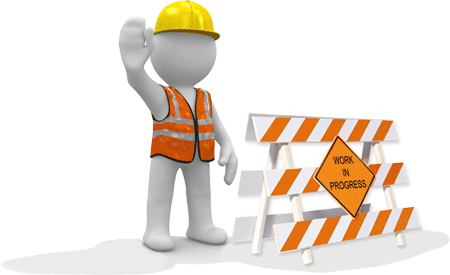